In [1]:
!pip install PyTDC

In [2]:
from tdc.single_pred import Tox

data = Tox(name='DILI')
split = data.get_split()

# train data
train = split['train']
y_train = train['Y']

# test data
test = split['test']
y_test = test['Y']

Found local copy...
Loading...
Done!


In [3]:
import rdkit.Chem as Chem
from rdkit.Chem import Descriptors

import pandas as pd
import numpy as np

In [4]:
# Function to conver SMILES to MOL

def smiles2mol(dataset):
    mols = [Chem.MolFromSmiles(mol) for mol in dataset['Drug']]
    return mols

train_mols = smiles2mol(train)
test_mols = smiles2mol(test)

In [5]:
# Function to convert Mol to RDKit Descriptor

def getMolDescriptors(mol, err=None):

    res = {}
    for nm,fn in Descriptors._descList:
        try:
            val = fn(mol)
        except:
            val = err
        res[nm] = val
    return res

In [6]:
# Function to convert Mol to RDKit Descriptor for all molecules in existing list

def rdkitdesc_conversion(mols, is_train = True):

    descrs = [getMolDescriptors(mol) for mol in mols]
    descrs_df = pd.DataFrame(descrs)

    return descrs_df

In [7]:
# Obtain dataframe of RDKit Descriptor for all molecules in train and test dataset

train_df = rdkitdesc_conversion(train_mols)
test_df = rdkitdesc_conversion(test_mols, is_train=False)

In [8]:
# Check if there is any NaN values in train/test descriptors dataframe

(train_df.isna()).sum().sum(), (test_df.isna()).sum().sum()

(24, 32)

In [9]:
# Replace NaN value with column-wise (Values for same single descriptor property) average value

train_df = train_df.fillna(train_df.mean())
test_df = test_df.fillna(test_df.mean())

In [10]:
# PCA + regression
from sklearn import decomposition, linear_model 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


In [11]:
scaler = StandardScaler()
scaled_train_df = scaler.fit_transform(train_df)
scaled_test_df = scaler.fit_transform(test_df)

In [12]:
scaled_train_df = pd.DataFrame(data=scaled_train_df, columns=train_df.columns)
scaled_test_df = pd.DataFrame(data=scaled_test_df, columns=test_df.columns)

In [13]:
pca = decomposition.PCA(n_components=10)
pca.fit(scaled_train_df)

print('PCA Explained Variance Ratio: ', pca.explained_variance_ratio_)
df_pca_component = pd.DataFrame(data = pca.components_, columns=train_df.columns)
df_pca_component.to_csv("pca_components.csv")

PCA Explained Variance Ratio:  [0.2178999  0.07157433 0.06021715 0.03863902 0.0375412  0.03047694
 0.02887742 0.02557197 0.0240376  0.02054968]


In [14]:
pc1_feature = list(zip(pca.components_[0], scaled_train_df.columns))
pc1_feature.sort(reverse=True)
pc1_feature

[(0.15034212240154207, 'NumValenceElectrons'),
 (0.14986966068265134, 'Chi0'),
 (0.14891194403750038, 'HeavyAtomCount'),
 (0.14833057758754334, 'LabuteASA'),
 (0.14779935029446656, 'Chi1'),
 (0.14674692863335406, 'Chi0v'),
 (0.14609675589081203, 'ExactMolWt'),
 (0.1460805682915294, 'MolWt'),
 (0.1460688168270488, 'Chi0n'),
 (0.14478427744192765, 'HeavyAtomMolWt'),
 (0.14425441033852388, 'Chi1v'),
 (0.1439601762664197, 'Chi1n'),
 (0.14345406995049298, 'MolMR'),
 (0.14183510992089687, 'Kappa1'),
 (0.13969564797750045, 'Chi2n'),
 (0.1368063606324936, 'Chi2v'),
 (0.13503821297260485, 'Kappa2'),
 (0.13335376557633694, 'Chi3v'),
 (0.13194522568445063, 'NOCount'),
 (0.1318868001882829, 'SlogP_VSA2'),
 (0.13182029672869205, 'Chi3n'),
 (0.13032122233470395, 'BertzCT'),
 (0.13020507181322583, 'NumHeteroatoms'),
 (0.1290462234097275, 'NumHAcceptors'),
 (0.12110560759619365, 'Chi4n'),
 (0.1207256045066824, 'TPSA'),
 (0.12042934875537924, 'Chi4v'),
 (0.12009685488463367, 'SMR_VSA1'),
 (0.1197328996

In [15]:
pc2_feature = list(zip(pca.components_[1], scaled_train_df.columns))
pc2_feature.sort(reverse=True)
pc2_feature

[(0.16443102924414052, 'NHOHCount'),
 (0.15626934202092266, 'NumHDonors'),
 (0.14972611020003265, 'TPSA'),
 (0.1416405348201402, 'fr_NH2'),
 (0.11604596597910322, 'NumHeteroatoms'),
 (0.11594881676992164, 'NOCount'),
 (0.1137241863397981, 'EState_VSA1'),
 (0.10681112237790781, 'BCUT2D_MWLOW'),
 (0.10434615786929635, 'PEOE_VSA1'),
 (0.10367190072006327, 'EState_VSA10'),
 (0.10197941796069038, 'SlogP_VSA1'),
 (0.10125440552917517, 'VSA_EState3'),
 (0.0989207581549227, 'BalabanJ'),
 (0.09627224282679028, 'MinAbsPartialCharge'),
 (0.09462927764551146, 'fr_NH1'),
 (0.09403193622945866, 'NumHAcceptors'),
 (0.09168556165274518, 'fr_Al_OH_noTert'),
 (0.09039666176341986, 'BCUT2D_CHGLO'),
 (0.08827125593831064, 'SMR_VSA1'),
 (0.08724890324086979, 'VSA_EState4'),
 (0.08563213994401155, 'PEOE_VSA10'),
 (0.08270092362423857, 'fr_amide'),
 (0.07979711282750612, 'fr_Al_OH'),
 (0.07959450977360469, 'FpDensityMorgan1'),
 (0.07781810548674063, 'fr_guanido'),
 (0.0754236519212612, 'MaxPartialCharge'),
 

In [16]:
pc1_feature = list(zip(pca.components_[2], scaled_train_df.columns))
pc1_feature.sort(reverse=True)
pc1_feature

[(0.20463869962116185, 'FractionCSP3'),
 (0.18956050890503234, 'NumAliphaticCarbocycles'),
 (0.185248897200001, 'NumSaturatedCarbocycles'),
 (0.18456868137027085, 'NumSaturatedRings'),
 (0.1768341749720152, 'NumAliphaticRings'),
 (0.15635738394710366, 'HallKierAlpha'),
 (0.14138734737425146, 'fr_Al_OH'),
 (0.13825666077259, 'SMR_VSA5'),
 (0.12273799451943104, 'BCUT2D_CHGHI'),
 (0.12230094176770355, 'fr_Al_OH_noTert'),
 (0.11155024002406, 'SMR_VSA4'),
 (0.10794758188754063, 'SlogP_VSA4'),
 (0.10530770503561858, 'fr_ketone_Topliss'),
 (0.10258680484714153, 'VSA_EState3'),
 (0.09624868348946185, 'Chi4n'),
 (0.09274494867182362, 'fr_ketone'),
 (0.09185328355153068, 'BCUT2D_LOGPHI'),
 (0.09002968820441129, 'fr_bicyclic'),
 (0.08685446143704206, 'SlogP_VSA5'),
 (0.07944746437931763, 'NumSaturatedHeterocycles'),
 (0.07385167596943468, 'Chi3n'),
 (0.0659959896887311, 'fr_lactone'),
 (0.06348168547071124, 'Chi4v'),
 (0.059495055304726124, 'NumAliphaticHeterocycles'),
 (0.059322439687828014, 'VS

In [17]:
train_pca_x = pca.transform(scaled_train_df)
test_pca_x = pca.transform(scaled_test_df)

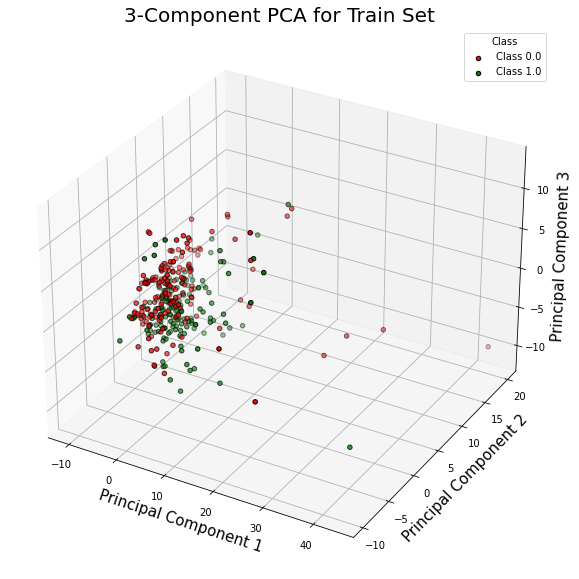

In [19]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

colors = {0: 'red', 1: 'green'}

for class_label in np.unique(y_train):
    idx = np.where(y_train == class_label)
    ax.scatter(train_pca_x[idx, 0], train_pca_x[idx, 1], train_pca_x[idx, 2], c=colors[class_label], label=f'Class {class_label}', edgecolor='k')

ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_zlabel('Principal Component 3', fontsize=15)
ax.set_title('3-Component PCA for Train Set', fontsize=20)
ax.grid(True)
ax.legend(title='Class')

plt.show()

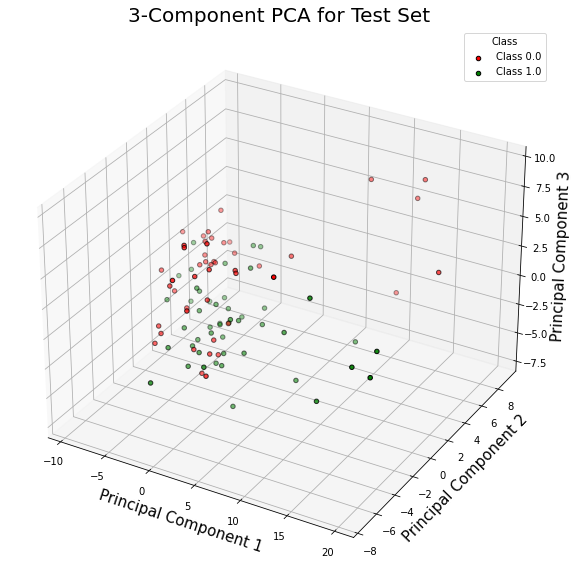

In [37]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

colors = {0: 'red', 1: 'green'}

for class_label in np.unique(y_test):
    idx = np.where(y_test == class_label)
    ax.scatter(test_pca_x[idx, 0], test_pca_x[idx, 1], test_pca_x[idx, 2], c=colors[class_label], label=f'Class {class_label}', edgecolor='k')

ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_zlabel('Principal Component 3', fontsize=15)
ax.set_title('3-Component PCA for Test Set', fontsize=20)
ax.grid(True)
ax.legend(title='Class')

plt.show()


In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [22]:
lasso = linear_model.Lasso(alpha=1.0, fit_intercept=True)
lasso_model = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2)),
    ("model", lasso)
])

lasso_model.fit(train_pca_x, y_train)
y_pred = lasso_model.predict(test_pca_x)
r2_lasso = lasso_model.score(test_pca_x, y_test)
lasso_predict = [1 if y_pred[i] >= 0.5 else 0 for i in range(len(y_pred))]

In [23]:
print("Mean squared error of Lasso regression: {:.2f}".format(mean_squared_error(y_test, lasso_predict)))
print(f"Lasso r2 score: {r2_lasso}")
print(f"Lasso coefficient: {lasso.coef_}")

Mean squared error of Lasso regression: 0.35
Lasso r2 score: 0.020520850365507437
Lasso coefficient: [ 0.         0.         0.        -0.        -0.        -0.
  0.        -0.         0.         0.        -0.        -0.
 -0.         0.         0.         0.        -0.         0.
  0.         0.        -0.0006843 -0.0012654  0.        -0.
 -0.        -0.        -0.         0.         0.         0.
 -0.         0.         0.         0.         0.         0.
 -0.         0.        -0.         0.         0.        -0.
  0.         0.        -0.        -0.        -0.         0.
 -0.         0.         0.        -0.         0.         0.
  0.        -0.        -0.        -0.         0.        -0.
  0.         0.        -0.         0.        -0.        -0.       ]


In [24]:
linear = linear_model.LinearRegression()
linear_regr_model = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2)),
    ("model", linear)
])
linear_regr_model.fit(train_pca_x, y_train)
linear_y_pred = linear_regr_model.predict(test_pca_x)
r2_linear_regr = linear_regr_model.score(test_pca_x, y_test)
linear_predict = [1 if linear_y_pred[i] >= 0.5 else 0 for i in range(len(linear_y_pred))]

In [25]:
print("Mean squared error of Linear regression: {:.2f}".format(mean_squared_error(y_test, linear_predict)) )
print(f"Linear r2 score: {r2_linear_regr}")
print(f"Linear coefficient: {linear.coef_}")

Mean squared error of Linear regression: 0.13
Linear r2 score: 0.4181100189149194
Linear coefficient: [-1.38922541e-16  1.46287339e-02  3.39199288e-02 -9.81657683e-02
 -4.29175628e-02 -2.93882659e-02  3.09564765e-02 -4.52310844e-02
 -1.22862727e-02  3.01372767e-02 -4.35440752e-02 -1.35265169e-04
 -2.01042147e-03  8.23889845e-04  3.89598518e-04  2.60952435e-05
 -3.34222053e-04 -4.59112812e-03  1.01450453e-03  9.60918977e-04
 -1.55591317e-03 -3.22342664e-03 -1.15887083e-02 -7.43055323e-04
 -4.83878079e-03 -4.17962697e-03 -4.29639024e-03 -8.61383602e-03
  5.95576803e-03 -7.28630704e-03  1.71469661e-03  6.14671852e-03
 -3.69021726e-03  2.73408023e-04  7.73102298e-03  4.62767466e-03
  4.99972747e-03  1.34008713e-02 -2.20847173e-03 -7.98399419e-03
  9.55324793e-04 -5.94848603e-03  9.29670486e-04  4.47967358e-03
  8.13875362e-03  5.48047417e-03 -1.89244798e-03 -1.10172560e-03
 -1.19667213e-02 -3.06626291e-03  5.49646245e-03 -4.96924379e-03
  2.76363531e-03  1.56448262e-02 -1.39721822e-02 -9.5

In [45]:
ridge = linear_model.Ridge()
ridge_model = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2)),
    ("model", ridge)
])

ridge_model.fit(train_pca_x, y_train)
ridge_y_pred = ridge_model.predict(test_pca_x)
r2_ridge = ridge_model.score(test_pca_x, y_test)
ridge_predict = [1 if ridge_y_pred[i] >= 0.5 else 0 for i in range(len(ridge_y_pred))]

In [46]:
print("Mean squared error of Ridge regression: {:.2f}".format(mean_squared_error(y_test, ridge_predict)) )
print(f"Ridge r2 score: {r2_ridge}")
print(f"Ridge coefficient: {ridge.coef_}")

Mean squared error of Ridge regression: 0.13
Ridge r2 score: 0.4187234337538275
Ridge coefficient: [ 0.00000000e+00  1.45867729e-02  3.38426550e-02 -9.80901862e-02
 -4.28684851e-02 -2.94648678e-02  3.08546454e-02 -4.50246067e-02
 -1.21939885e-02  3.00545393e-02 -4.33177698e-02 -1.30385063e-04
 -2.00158029e-03  8.27257676e-04  3.94089612e-04  1.62340180e-05
 -3.43751833e-04 -4.57920625e-03  1.02901893e-03  9.45942547e-04
 -1.55291048e-03 -3.21697588e-03 -1.15565298e-02 -7.45417390e-04
 -4.85002853e-03 -4.19012580e-03 -4.29952375e-03 -8.59789817e-03
  5.95682426e-03 -7.26743643e-03  1.72210578e-03  6.14177167e-03
 -3.68354106e-03  2.85301300e-04  7.72948146e-03  4.61657784e-03
  4.97844856e-03  1.33691551e-02 -2.21170504e-03 -7.96296960e-03
  9.68806787e-04 -5.95219091e-03  9.28573152e-04  4.46771094e-03
  8.12900237e-03  5.46820927e-03 -1.92970066e-03 -1.09779212e-03
 -1.19426736e-02 -3.06348831e-03  5.49985708e-03 -4.97236208e-03
  2.74446780e-03  1.56258207e-02 -1.39470448e-02 -9.5429

In [47]:
from sklearn.svm import SVC 

svm_model = SVC(kernel='rbf')
svm_model.fit(train_pca_x[:, :3], y_train)
svm_y_pred = svm_model.predict(test_pca_x[:, :3])
r2_svm = svm_model.score(test_pca_x[:, :3], y_test)

In [48]:
print("Mean squared error of SVM: {:.2f}".format(mean_squared_error(y_test, svm_y_pred)) )
print(f"R2 SVM score: {r2_svm}")

Mean squared error of SVM: 0.15
R2 SVM score: 0.8526315789473684


In [ ]:
x_min, x_max = test_pca_x[:, 0].min() - 1, test_pca_x[:, 0].max() + 1
y_min, y_max = test_pca_x[:, 1].min() - 1, test_pca_x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

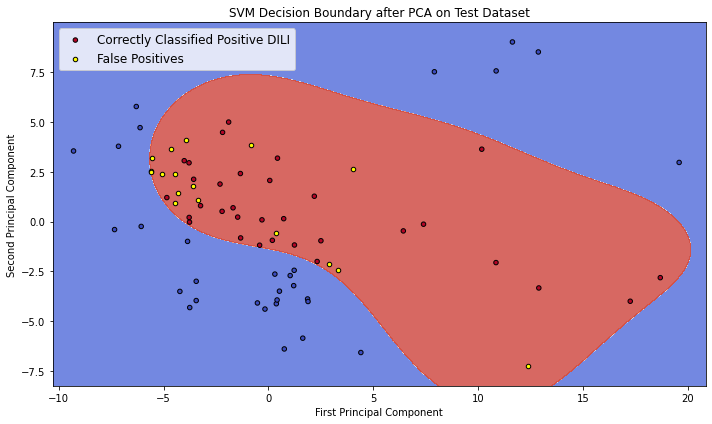

In [ ]:
correct_points = svm_y_pred == y_test
false_positive = (svm_y_pred == 1) & (y_test == 0)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(test_pca_x[correct_points, 0], test_pca_x[correct_points, 1], c=y_test[correct_points], label='Correctly Classified Positive DILI', s=20, edgecolor='k', cmap=plt.cm.coolwarm)
plt.scatter(test_pca_x[false_positive, 0], test_pca_x[false_positive, 1], c='yellow', label='False Positives', s=20, edgecolor='k', cmap=plt.cm.coolwarm)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('SVM Decision Boundary after PCA on Test Dataset')
plt.legend(loc='best', fontsize='large')
plt.tight_layout()
plt.show()

In [ ]:
# K-Means Clustering
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

kmeans inertia for k=1. 1.2285385711681316e+41
kmeans inertia for k=2. 8.966223943864289e+39
kmeans inertia for k=3. 1.5713940131469523e+32
kmeans inertia for k=4. 1.2212316111968404e+29
kmeans inertia for k=5. 4.81061620212158e+28
kmeans inertia for k=6. 2.9887938481713512e+26
kmeans inertia for k=7. 2.6795855334903417e+25
kmeans inertia for k=8. 5.438519490295312e+24
kmeans inertia for k=9. 1.0641499932198129e+23
kmeans inertia for k=10. 1.3939804378199008e+22
kmeans inertia for k=11. 1.3896371079686868e+22
kmeans inertia for k=12. 2.1571053394775216e+21
kmeans inertia for k=13. 1.4742705594902538e+20
kmeans inertia for k=14. 1.4703167146152182e+20
kmeans inertia for k=15. 1.4687408172591183e+20
kmeans inertia for k=16. 1.6732653042615216e+20
kmeans inertia for k=17. 1.6665546830761004e+20
kmeans inertia for k=18. 1.6828029977146016e+20
kmeans inertia for k=19. 1.6798293035217096e+20
kmeans inertia for k=20. 1.2920020040746256e+20
kmeans inertia for k=21. 1.688430280687104e+20
kmeans

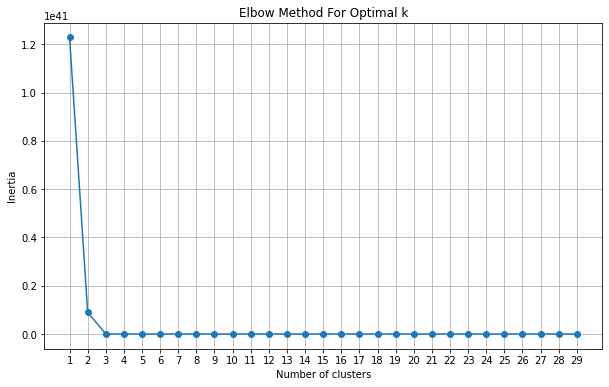

In [ ]:
# find the optimal number of KMeans clusters
def get_KMeans_sum_of_squared_distances(X, K_range):
    inertia = []
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

        print(f'kmeans inertia for k={k}. {kmeans.inertia_}')

    return inertia

k_values = range(1, 30)
inertia = get_KMeans_sum_of_squared_distances(train_df, k_values)

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# elbow point at k=2

In [ ]:
def perform_TSNE():
    tsne = TSNE(perplexity=30, n_components=2, init='random', random_state=42)
    data_proj = tsne.fit_transform(scaled_test_df)
    kmeans = KMeans(n_clusters=2, random_state=42)
    tsne_cluster_labels = kmeans.fit_predict(data_proj)
    df_tsne_clusters = pd.DataFrame(data=tsne_cluster_labels, columns=['TSNE Clusters'])
    df_scaled_test_with_columns = pd.DataFrame(data=scaled_test_df, columns=test_df.columns)
    df_test_tsne_clusters = pd.concat([df_scaled_test_with_columns, df_tsne_clusters], axis=1)

    plt.figure(figsize=(16, 16))
    plt.scatter(data_proj[:, 0], data_proj[:, 1], c=tsne_cluster_labels, cmap='viridis', alpha=0.6)
    plt.title('KMeans Clustering on t-SNE Projections')
    plt.xlabel('tSNE Feature 1')
    plt.ylabel('tSNE Feature 2')
    plt.colorbar(label='Cluster')
    plt.show()

    return df_test_tsne_clusters, tsne_cluster_labels


def perform_PCA():
    pca = decomposition.PCA(n_components=2, random_state=42)
    data_proj = pca.fit_transform(scaled_test_df)
    kmeans = KMeans(n_clusters=2, random_state=42)
    pca_cluster_labels = kmeans.fit_predict(data_proj)
    df_pca_clusters = pd.DataFrame(data=pca_cluster_labels, columns=['PCA Clusters'])
    df_scaled_test_with_columns = pd.DataFrame(data=scaled_test_df, columns=test_df.columns)
    df_test_pca_clusters = pd.concat([df_scaled_test_with_columns, df_pca_clusters], axis=1)

    plt.figure(figsize=(16, 16))
    plt.scatter(data_proj[:, 0], data_proj[:, 1], c=pca_cluster_labels, cmap='viridis', alpha=0.6)
    plt.title('KMeans Clustering on PCA Projections')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.colorbar(label='Cluster')
    plt.show()

    return df_test_pca_clusters, pca_cluster_labels


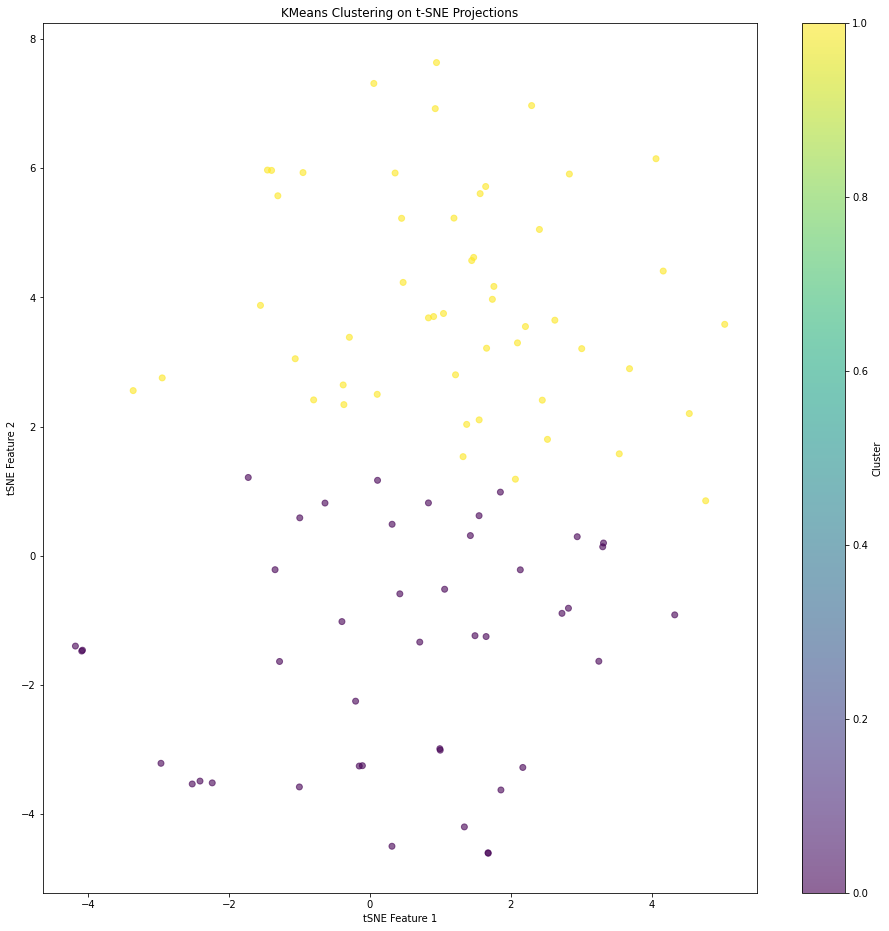

In [ ]:
df_test_tsne_clusters, tsne_cluster_labels = perform_TSNE()

In [ ]:
df_test_tsne_clusters

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,TSNE Clusters
0,0.722444,-0.465804,0.722444,-0.403672,-0.478574,0.272514,0.276016,0.274479,0.317137,-0.103142,...,-0.303239,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,0
1,-1.836818,1.040596,-1.836818,0.253767,-0.299994,-0.981575,-0.952785,-0.981118,-1.038256,-0.103142,...,-0.303239,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,1
2,-1.669930,0.490690,-1.669930,0.760383,0.146454,-0.267220,-0.187455,-0.282504,-0.802536,-0.103142,...,-0.303239,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,1
3,0.033776,0.146621,0.033776,-0.497153,1.461582,-0.236476,-0.185701,-0.241127,-0.419490,-0.103142,...,-0.303239,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,1
4,1.067840,-0.164816,1.067840,-0.523047,-1.712039,1.928527,1.907507,1.929107,1.996647,-0.103142,...,-0.303239,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,-2.006156,1.238840,-2.006156,1.134198,-0.056764,-1.068330,-1.040204,-1.067905,-1.126652,-0.103142,...,-0.303239,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,1
91,-0.151785,0.288410,-0.151785,-0.315473,0.157860,-1.016081,-1.065549,-1.015219,-0.890931,-0.103142,...,-0.303239,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,1
92,0.377618,-1.881747,0.377618,-0.161050,1.153180,-0.472383,-0.427938,-0.472410,-0.625745,-0.103142,...,3.297726,-0.103142,-0.146647,-0.103142,9.695360,0.0,-0.146647,-0.246737,-0.197642,1
93,0.204704,-1.856867,0.204704,-0.523897,0.511012,-0.166205,-0.116088,-0.165793,-0.242699,-0.103142,...,3.297726,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,1


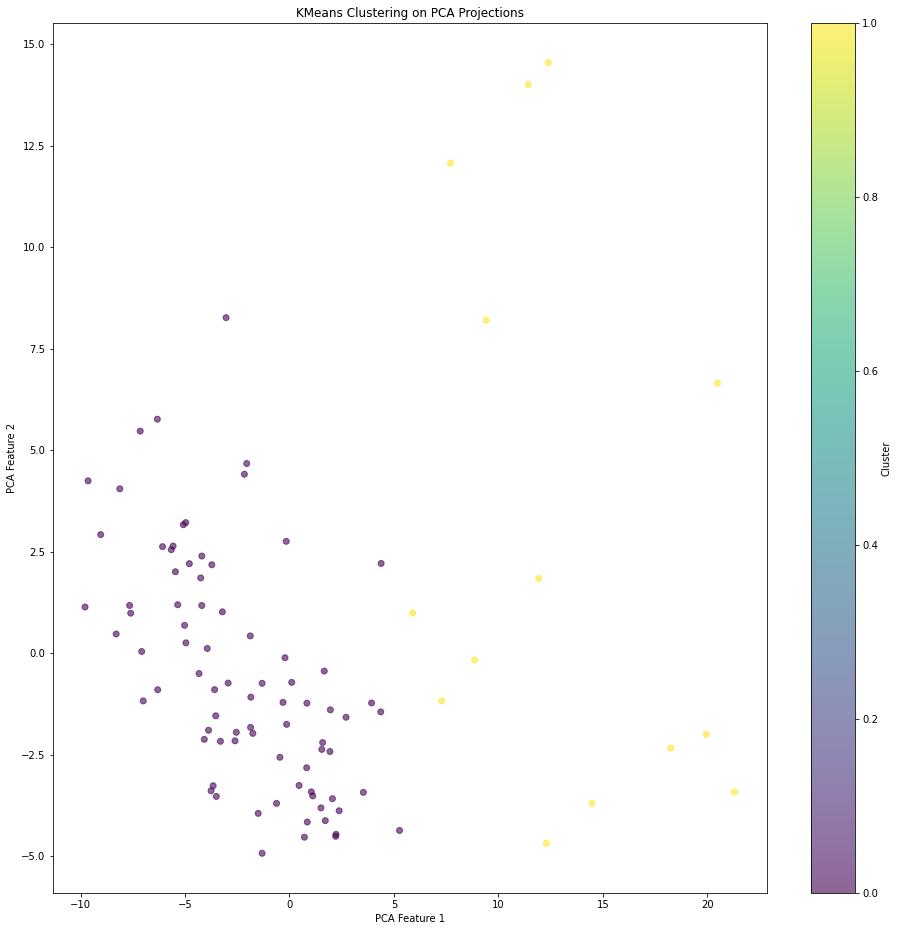

In [ ]:
df_test_pca_clusters, pca_cluster_labels = perform_PCA()

In [ ]:
df_test_pca_clusters

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,PCA Clusters
0,0.722444,-0.465804,0.722444,-0.403672,-0.478574,0.272514,0.276016,0.274479,0.317137,-0.103142,...,-0.303239,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,0
1,-1.836818,1.040596,-1.836818,0.253767,-0.299994,-0.981575,-0.952785,-0.981118,-1.038256,-0.103142,...,-0.303239,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,0
2,-1.669930,0.490690,-1.669930,0.760383,0.146454,-0.267220,-0.187455,-0.282504,-0.802536,-0.103142,...,-0.303239,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,0
3,0.033776,0.146621,0.033776,-0.497153,1.461582,-0.236476,-0.185701,-0.241127,-0.419490,-0.103142,...,-0.303239,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,0
4,1.067840,-0.164816,1.067840,-0.523047,-1.712039,1.928527,1.907507,1.929107,1.996647,-0.103142,...,-0.303239,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,-2.006156,1.238840,-2.006156,1.134198,-0.056764,-1.068330,-1.040204,-1.067905,-1.126652,-0.103142,...,-0.303239,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,0
91,-0.151785,0.288410,-0.151785,-0.315473,0.157860,-1.016081,-1.065549,-1.015219,-0.890931,-0.103142,...,-0.303239,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,0
92,0.377618,-1.881747,0.377618,-0.161050,1.153180,-0.472383,-0.427938,-0.472410,-0.625745,-0.103142,...,3.297726,-0.103142,-0.146647,-0.103142,9.695360,0.0,-0.146647,-0.246737,-0.197642,0
93,0.204704,-1.856867,0.204704,-0.523897,0.511012,-0.166205,-0.116088,-0.165793,-0.242699,-0.103142,...,3.297726,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,0


In [ ]:
all_df = df_test_pca_clusters
all_df['TSNE Clusters'] = tsne_cluster_labels
all_df

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,PCA Clusters,TSNE Clusters
0,0.722444,-0.465804,0.722444,-0.403672,-0.478574,0.272514,0.276016,0.274479,0.317137,-0.103142,...,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,0,0
1,-1.836818,1.040596,-1.836818,0.253767,-0.299994,-0.981575,-0.952785,-0.981118,-1.038256,-0.103142,...,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,0,1
2,-1.669930,0.490690,-1.669930,0.760383,0.146454,-0.267220,-0.187455,-0.282504,-0.802536,-0.103142,...,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,0,1
3,0.033776,0.146621,0.033776,-0.497153,1.461582,-0.236476,-0.185701,-0.241127,-0.419490,-0.103142,...,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,0,1
4,1.067840,-0.164816,1.067840,-0.523047,-1.712039,1.928527,1.907507,1.929107,1.996647,-0.103142,...,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,-2.006156,1.238840,-2.006156,1.134198,-0.056764,-1.068330,-1.040204,-1.067905,-1.126652,-0.103142,...,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,0,1
91,-0.151785,0.288410,-0.151785,-0.315473,0.157860,-1.016081,-1.065549,-1.015219,-0.890931,-0.103142,...,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,0,1
92,0.377618,-1.881747,0.377618,-0.161050,1.153180,-0.472383,-0.427938,-0.472410,-0.625745,-0.103142,...,-0.103142,-0.146647,-0.103142,9.695360,0.0,-0.146647,-0.246737,-0.197642,0,1
93,0.204704,-1.856867,0.204704,-0.523897,0.511012,-0.166205,-0.116088,-0.165793,-0.242699,-0.103142,...,-0.103142,-0.146647,-0.103142,-0.103142,0.0,-0.146647,-0.246737,-0.197642,0,1


In [ ]:
from scipy.stats import f_oneway

# ANOVA for each feature across clusters
for feature in all_df.columns[:-2]:  # Exclude the cluster label column
    cluster_groups = [group[feature].values for name, group in all_df.groupby('TSNE Clusters')]
    f_val, p_val = f_oneway(*cluster_groups)
    print(f"Feature: {feature}, F-value: {f_val}, p-value: {p_val}")

Feature: MaxEStateIndex, F-value: 64.77959666835527, p-value: 2.6828322951007723e-12
Feature: MinEStateIndex, F-value: 8.844640725739572, p-value: 0.0037439592410666283
Feature: MaxAbsEStateIndex, F-value: 64.77959666835527, p-value: 2.6828322951007723e-12
Feature: MinAbsEStateIndex, F-value: 9.767179056373712, p-value: 0.002370171453861933
Feature: qed, F-value: 1.4616167188295381, p-value: 0.2297377641111296
Feature: MolWt, F-value: 59.767378575718965, p-value: 1.2316807959346787e-11
Feature: HeavyAtomMolWt, F-value: 58.704931782452086, p-value: 1.7127587398051602e-11
Feature: ExactMolWt, F-value: 59.8428150848223, p-value: 1.2032894686045222e-11
Feature: NumValenceElectrons, F-value: 69.30978131938164, p-value: 7.059914247426391e-13
Feature: NumRadicalElectrons, F-value: 0.8614736842105257, p-value: 0.35572931071196257
Feature: MaxPartialCharge, F-value: 1.0214012954437832, p-value: 0.31480909894801984
Feature: MinPartialCharge, F-value: 0.5663793201710609, p-value: 0.45360199936923